### Import Library

In [1]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

import pandas as pd
import numpy as np
import networkx as nx
import pickle

from glob import glob
from tqdm import tqdm

from collections import defaultdict
from datetime import date
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, mean_squared_error, r2_score, mean_absolute_error

### Plot_Style

In [27]:
def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
#               'font.family': 'sans-serif',
#               'font.sans-serif': ['Helvetica'],
#'text.latex.unicode': True,
              'text.latex.preamble': str([r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ]),
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': 25,
              'ytick.labelsize': 25,
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams)

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=False)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

### Figiures

In [3]:
df_simultaneousClassification_BTF = pd.read_csv("data/results/Air_Classification_BTF_simultaneous.csv")[['Year','Removed','simultaneous_pred','simultaneous_null']]
df_simultaneousClassification_WTF = pd.read_csv("data/results/Air_Classification_WTF_simultaneous.csv")[['Year','Removed','simultaneous_pred','simultaneous_null']]
df_simultaneousClassification_WWW = pd.read_csv("data/results/Air_Classification_WWW_simultaneous.csv")[['Year','Removed','simultaneous_pred','simultaneous_null']]
df_simultaneousClassification_BTFW = pd.read_csv("data/results/Air_Classification_BTFW_simultaneous.csv")[['Year','Removed','simultaneous_pred','simultaneous_null']]

In [4]:
df_simultaneousClassification = {'Unweighted Topological Features': df_simultaneousClassification_BTF,
                                 'Weighted Topological Features': df_simultaneousClassification_WTF,
                                 'Weight (Number of Flights)': df_simultaneousClassification_WWW,
                                 'Unweighted Topological Features + Weight': df_simultaneousClassification_BTFW
                                }

In [5]:
def pure_plot_confusion_matrix(cm, ax = None):
    classes = ['Retained','Removed']
    sns.heatmap(cm, square = True, annot= True, cbar = False, cmap=plt.cm.Blues,ax = ax,annot_kws={"fontsize":25})
    ax.set_ylim(0,2)
    ax.tick_params( bottom=False, right=False,left=False, labeltop=False, labelbottom=True)
    ax.invert_yaxis()
    ax.set(xticks = np.arange(cm.shape[1])+0.5,
           yticks = np.arange(cm.shape[0])+0.25,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel = 'True label',
           xlabel = 'Predicted label') 

In [29]:
import sys

sys.path.append("..")
stdrcparams(usetex=False)

import warnings
warnings.simplefilter(action='ignore')

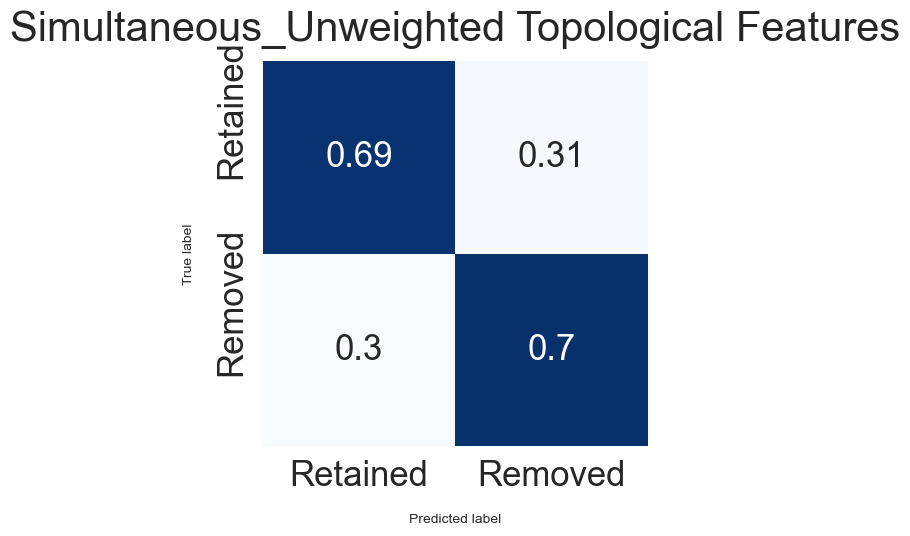

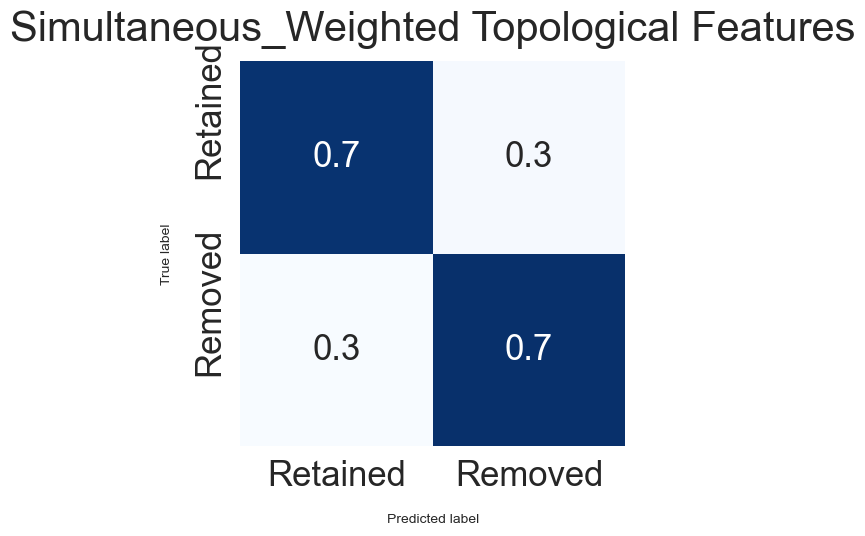

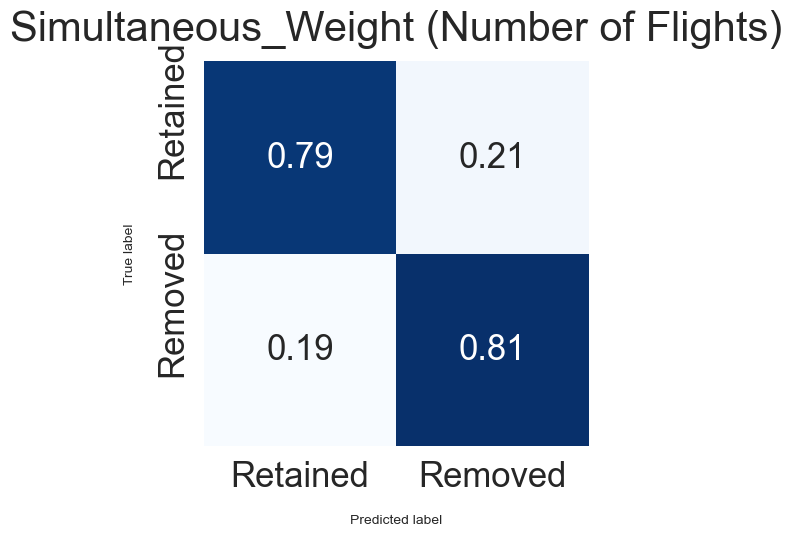

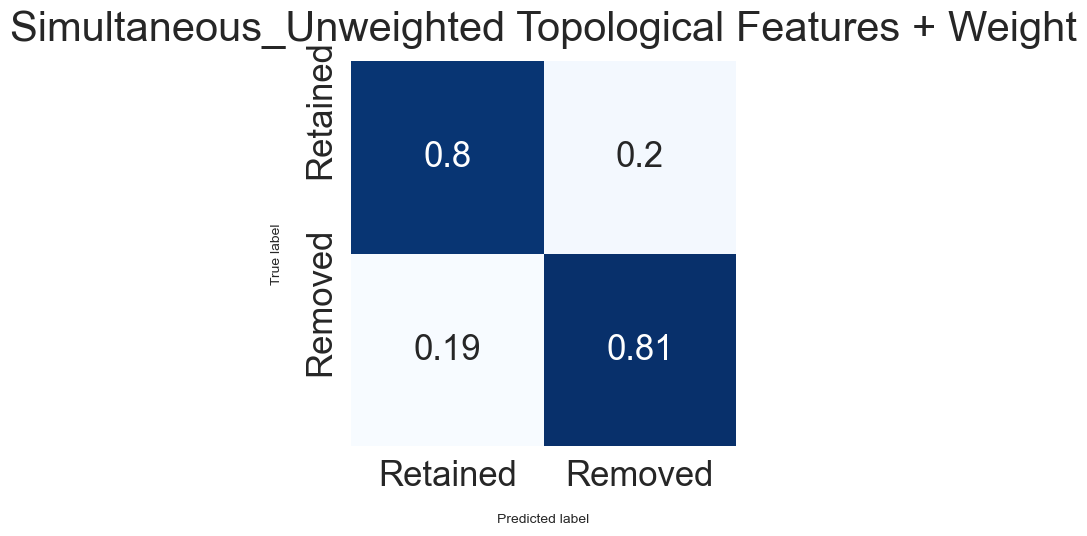

In [33]:
# generating and displaying confusion matrices for each item in the simultaneousClassification in sample 2008
year = '2008-01-01'
for name,df in df_simultaneousClassification.items():
    df["Removed"] = df["Removed"].astype(int)
    y_test, y_predict = df[df.Year==year][['Removed','simultaneous_pred']].values.T
    cm = confusion_matrix(y_test, y_predict)
    cm = cm.astype('float') / cm.sum(axis = 1)[:,None]
    fig,ax = plt.subplots(figsize=(5,5))
    plt.title(f"Simultaneous_{name}")
    pure_plot_confusion_matrix(cm, ax=ax)
    plt.show()

In [34]:
# calculating the balanced accuracy score for a binary classification model ("simultaneous_pred") 
# and a null model ("simultaneous_null") on a yearly basis, for each model in simultaneousClassification. 
# The balanced accuracy score is a metric that takes into account both the true positive rate and true negative rate, 
# and is commonly used for imbalanced datasets.

from datetime import datetime,date

# extracting the unique years
year_list = df_simultaneousClassification_BTF.Year.unique()

# balanced_acc is created to store the results of the balanced accuracy scores for each year and model.
balanced_acc = defaultdict(list)
for name,df in df_simultaneousClassification.items():
    df["Removed"] = df["Removed"].astype(int)
    for year in year_list:  
        if datetime.strptime(year, '%Y-%m-%d').date()>date(2018,12,1):continue
        y_test, y_predict, y_null = df[df.Year==year][['Removed','simultaneous_pred','simultaneous_null']].values.T
        balanced_acc['Balanced Acc'].append(balanced_accuracy_score(y_test, y_predict))
        balanced_acc['Balanced Acc Null'].append(balanced_accuracy_score(y_test, y_null))
        balanced_acc['Model'].append(name)

In [35]:
df = pd.DataFrame(balanced_acc)
df = df.groupby('Model').mean()
df

,Balanced Acc,Balanced Acc Null
Model,,
Unweighted Topological Features,0.692087,0.500181
Unweighted Topological Features + Weight,0.798282,0.501706
Weight (Number of Flights),0.811196,0.532639
Weighted Topological Features,0.703097,0.497463


In [36]:
with open("data/results/Air_Classification_BTF_nonsimultaneous.pkl",'rb') as f:    
    df_nonsimultaneousClassification_BTF = pickle.load(f)
with open("data/results/Air_Classification_WTF_nonsimultaneous.pkl",'rb') as f:    
    df_nonsimultaneousClassification_WTF = pickle.load(f)
with open("data/results/Air_Classification_WWW_nonsimultaneous.pkl",'rb') as f:    
    df_nonsimultaneousClassification_WWW = pickle.load(f)
with open("data/results/Air_Classification_BTFW_nonsimultaneous.pkl",'rb') as f:    
    df_nonsimultaneousClassification_BTFW = pickle.load(f)

In [37]:
df_nonsimultaneousClassification = {'Unweighted Topological Features': df_nonsimultaneousClassification_BTF,
                                     'Weighted Topological Features': df_nonsimultaneousClassification_WTF,
                                     'Weight (Number of Flights)': df_nonsimultaneousClassification_WWW,
                                     'Unweighted Topological Features + Weight': df_nonsimultaneousClassification_BTFW}

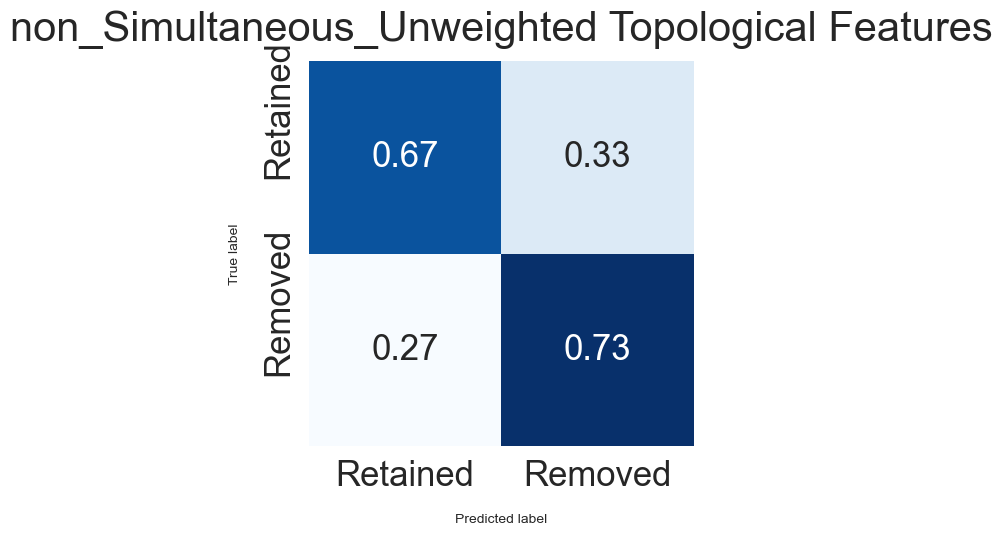

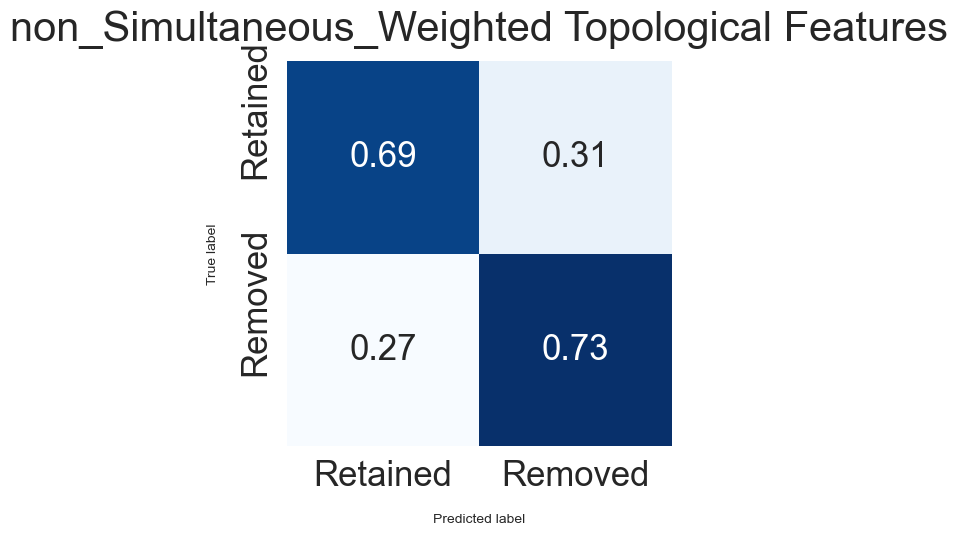

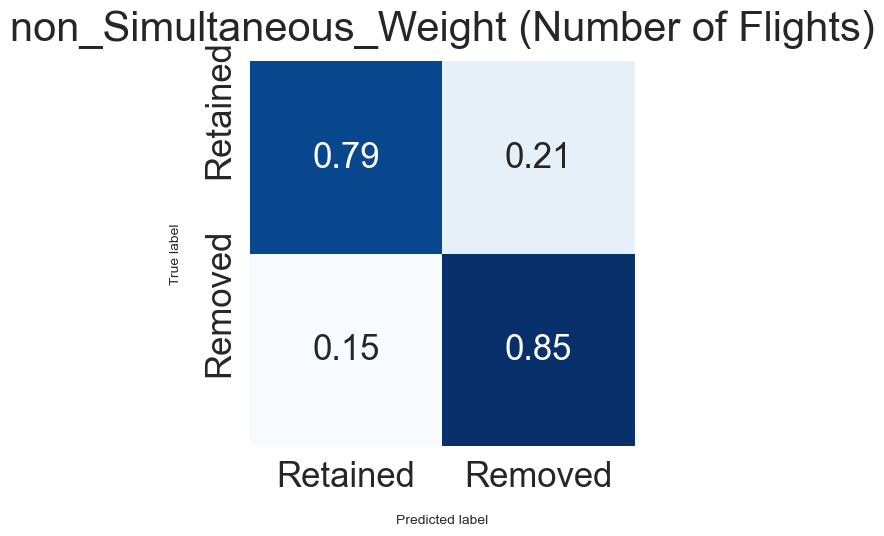

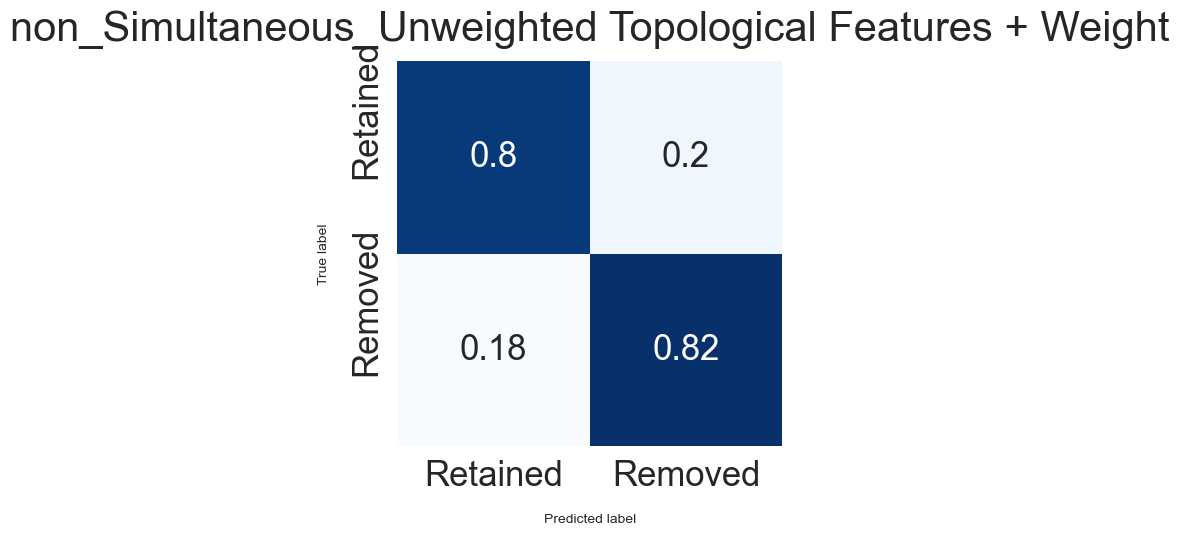

In [69]:
year0 = '2009-01-01'
year1 = '2009-03-01'
for name,df in df_nonsimultaneousClassification.items():
    for year_train , year_test, y_test, y_pred, y_null in df:
        if year_train==year0 and year_test==year1: 
            break # If the year_train is equal to '2009-01-01' and the year_test is equal to '2009-03-01', the loop is broken.
    y_test, y_predict = y_test, y_pred
    cm = confusion_matrix(y_test, y_predict)
    cm = cm.astype('float') / cm.sum(axis = 1)[:,None]
    fig,ax = plt.subplots(figsize=(5,5))
    plt.title(f"non_Simultaneous_{name}")
    pure_plot_confusion_matrix(cm, ax=ax)
    plt.show()

In [39]:
# define the period after 2019 as "Travel restrictions"
# compare two period bbetween Balanced Acc and 

from collections import defaultdict
from datetime import datetime,date
balanced_acc_non = defaultdict(list)
for name, df in df_nonsimultaneousClassification.items():
    for year_train , year_test, y_test, y_pred, y_null in df:
        if year_train!=year_test and datetime.strptime(year_train, '%Y-%m-%d').date()<date(2018,12,1):
            balanced_acc_non['Balanced Acc'].append(balanced_accuracy_score(y_test, y_pred))
            balanced_acc_non['Balanced Acc Null'].append(balanced_accuracy_score(y_test, y_null))
            balanced_acc_non['Model'].append(name)
            if datetime.strptime(year_test, '%Y-%m-%d').date()>date(2018,12,1): 
                balanced_acc_non['Time'].append('Travel restrictions')
            else:
                balanced_acc_non['Time'].append('Before 2019')

In [40]:
df = pd.DataFrame(balanced_acc_non)
df = df.groupby(['Model','Time']).mean()
df

Balanced Acc  \
Model                                    Time                                
Unweighted Topological Features          Before 2019              0.671945   
                                         Travel restrictions      0.660094   
Unweighted Topological Features + Weight Before 2019              0.789305   
                                         Travel restrictions      0.768014   
Weight (Number of Flights)               Before 2019              0.807746   
                                         Travel restrictions      0.787124   
Weighted Topological Features            Before 2019              0.682249   
                                         Travel restrictions      0.661478   

                                                              Balanced Acc Null  
Model                                    Time                                    
Unweighted Topological Features          Before 2019                   0.500717  
                                         Travel restrictions           0.500522  
Unweighted Topological Features + Weight Before 2019                   0.499126  
                                         Travel restrictions           0.498405  
Weight (Number of Flights)               Before 2019                   0.507488  
                                         Travel restrictions           0.507378  
Weighted Topological Features            Before 2019                   0.499054  
                                         Travel restrictions           0.499491

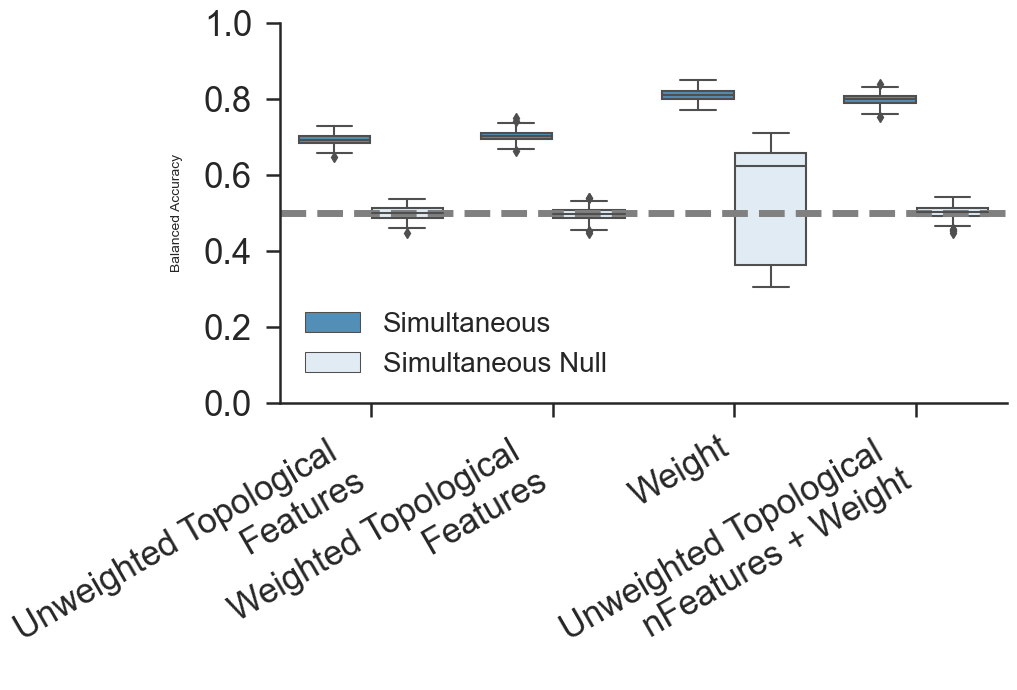

In [43]:
# generates a boxplot visualization of the balanced accuracy scores for several models in two different test scenarios: 
# simultaneous and non-simultaneous. 

# The boxplot shows the distribution of balanced accuracy scores for each model, separately 
# for the simultaneous and non-simultaneous tests. The plot also includes a horizontal line at the 0.5 mark, 
# which indicates the balanced accuracy score for random guessing. 

stdrcparams(usetex=False)
df1 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc']]
df1['Test'] = 'Simultaneous'
df2 = pd.DataFrame(balanced_acc_non)[['Model','Balanced Acc']]
df2['Test'] = 'Non-Simultaneous'
df3 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df3['Test'] = 'Simultaneous Null'
df4 = pd.DataFrame(balanced_acc_non)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df4['Test'] = 'Non-Simultaneous Null'
df = pd.concat([df1,df3])
models=[ 'Unweighted Topological Features',
         'Weighted Topological Features',
         'Weight (Number of Flights)',
         'Unweighted Topological Features + Weight']
xlbls=[ 'Unweighted Topological \nFeatures',
         'Weighted Topological \nFeatures',
         'Weight',
         'Unweighted Topological \nnFeatures + Weight']
df = df[df.Model.isin(models)]
fig,ax = plt.subplots(figsize=(xs*0.9,ys))
ax = sns.boxplot(x="Model", y="Balanced Acc",hue='Test',
                 palette=sns.color_palette(['#4292c6','#deebf7']),#,'#41ab5d','#e5f5e0']),
                 data=df,ax=ax,linewidth=1.5,
                 hue_order=['Simultaneous','Simultaneous Null'])#,'Non-Simultaneous','Non-Simultaneous Null'])
custom_frame(ax)
plt.ylabel('Balanced Accuracy')
plt.xlabel('')
plt.xticks(range(4),xlbls)
plt.xticks(rotation=30, ha='right')
plt.legend(frameon=False)
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

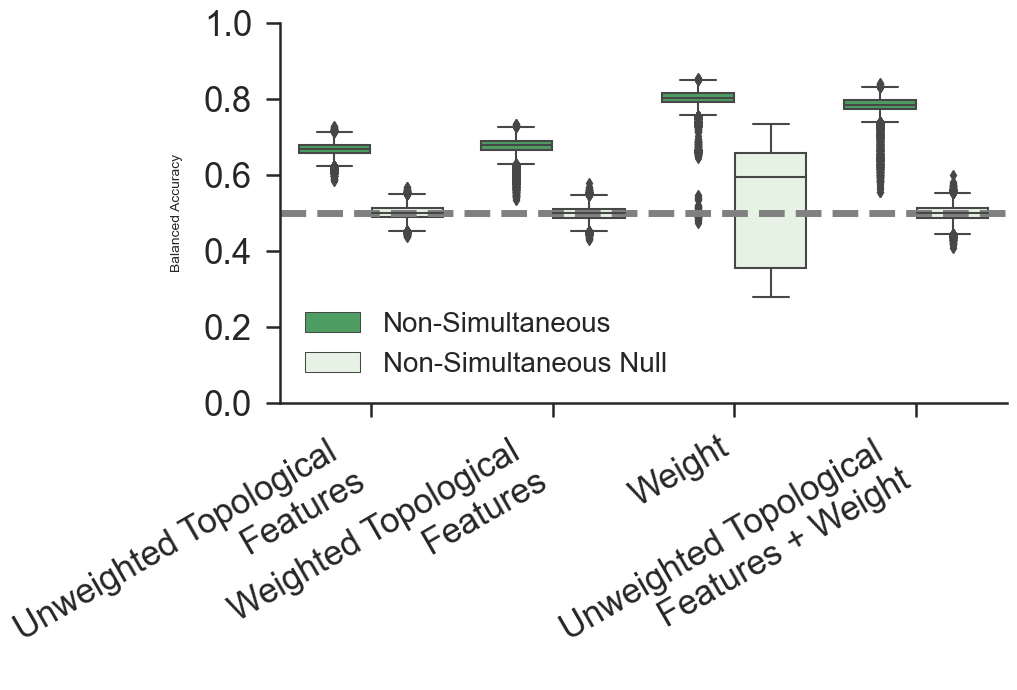

In [44]:
stdrcparams(usetex=False)
df1 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc']]
df1['Test'] = 'Simultaneous'
df2 = pd.DataFrame(balanced_acc_non)[['Model','Balanced Acc']]
df2['Test'] = 'Non-Simultaneous'
df3 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df3['Test'] = 'Simultaneous Null'
df4 = pd.DataFrame(balanced_acc_non)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df4['Test'] = 'Non-Simultaneous Null'
df = pd.concat([df2,df4])
models=[ 'Unweighted Topological Features',
         'Weighted Topological Features',
         'Weight (Number of Flights)',
         'Unweighted Topological Features + Weight']
xlbls=[ 'Unweighted Topological \nFeatures',
         'Weighted Topological \nFeatures',
         'Weight',
         'Unweighted Topological \nFeatures + Weight']
df = df[df.Model.isin(models)]
fig,ax = plt.subplots(figsize=(xs*0.9,ys))
ax = sns.boxplot(x="Model", y="Balanced Acc",hue='Test',
                 palette=sns.color_palette(['#41ab5d','#e5f5e0']),#,'#41ab5d','#e5f5e0']),
                 data=df,ax=ax,linewidth=1.5,
                 hue_order=['Non-Simultaneous','Non-Simultaneous Null'])#,'Non-Simultaneous','Non-Simultaneous Null'])
custom_frame(ax)
plt.ylabel('Balanced Accuracy')
plt.xlabel('')
plt.xticks(range(4),xlbls)
plt.xticks(rotation=30, ha='right')
plt.legend(frameon=False)
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

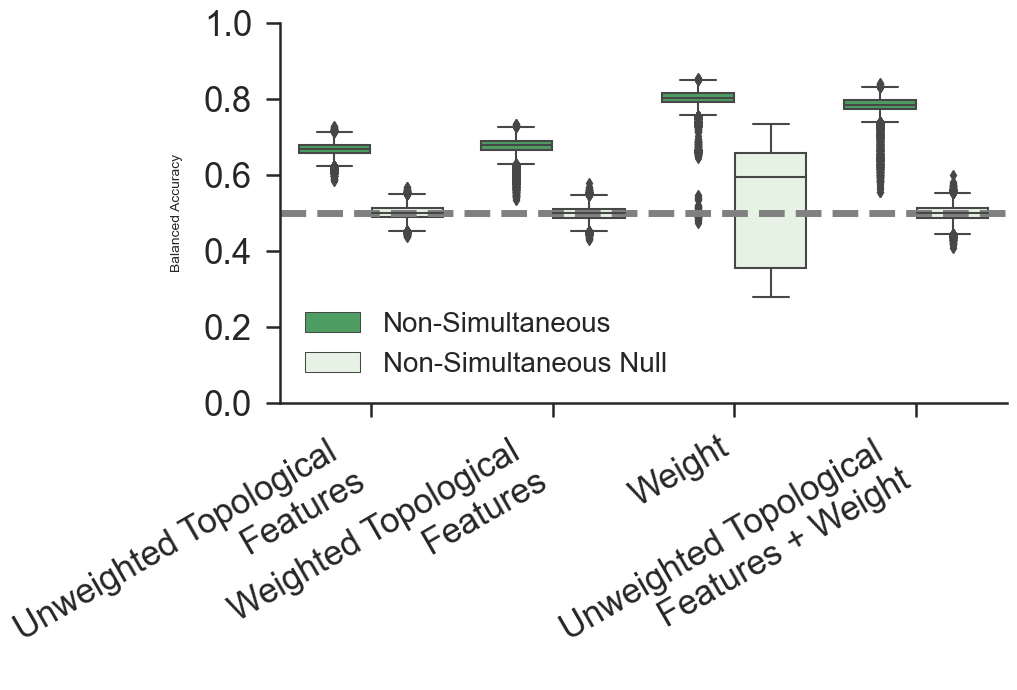

In [45]:
stdrcparams(usetex=False)
df1 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc']]
df1['Test'] = 'Simultaneous'
df2 = pd.DataFrame(balanced_acc_non)[['Model','Balanced Acc']]
df2['Test'] = 'Non-Simultaneous'
df3 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df3['Test'] = 'Simultaneous Null'
df4 = pd.DataFrame(balanced_acc_non)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df4['Test'] = 'Non-Simultaneous Null'
df = pd.concat([df2,df4])
models=[ 'Unweighted Topological Features',
         'Weighted Topological Features',
         'Weight (Number of Flights)',
         'Unweighted Topological Features + Weight']
xlbls=[ 'Unweighted Topological \nFeatures',
         'Weighted Topological \nFeatures',
         'Weight',
         'Unweighted Topological \nFeatures + Weight']
df = df[df.Model.isin(models)]
fig,ax = plt.subplots(figsize=(xs*0.9,ys))
ax = sns.boxplot(x="Model", y="Balanced Acc",hue='Test',
                 palette=sns.color_palette(['#41ab5d','#e5f5e0']),#,'#41ab5d','#e5f5e0']),
                 data=df,ax=ax,linewidth=1.5,
                 hue_order=['Non-Simultaneous','Non-Simultaneous Null'])#,'Non-Simultaneous','Non-Simultaneous Null'])
custom_frame(ax)
plt.ylabel('Balanced Accuracy')
plt.xlabel('')
plt.xticks(range(4),xlbls)
plt.xticks(rotation=30, ha='right')
plt.legend(frameon=False)
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

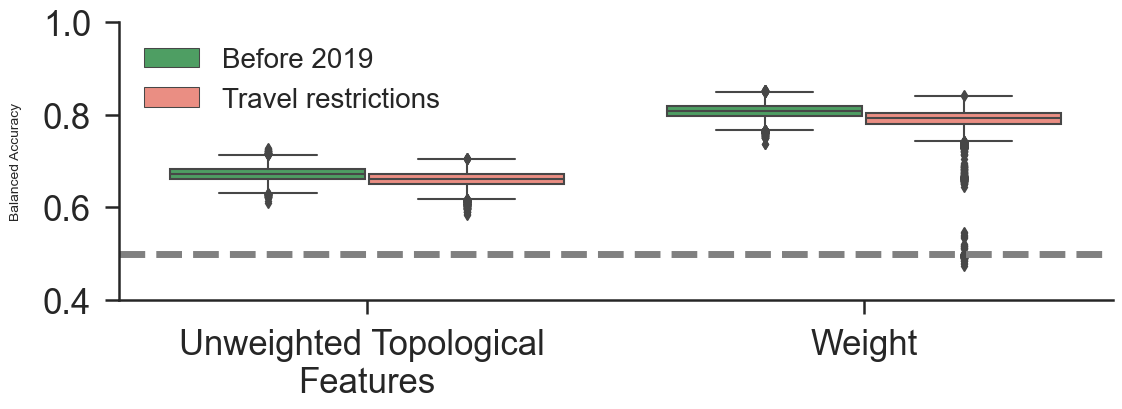

In [70]:
# creates a boxplot of balanced accuracy scores for two different models 
# ('Unweighted Topological Features' and 'Weight (Number of Flights)') 
# under two different time periods ('Before 2019' and 'Travel restrictions').

stdrcparams(usetex=False)
df = pd.DataFrame(balanced_acc_non)
models=[ 'Unweighted Topological Features',
         'Weight (Number of Flights)',
       ]
xlbls=[ 'Unweighted Topological \nFeatures',
         'Weight',
      ]

df = df[df.Model.isin(models)]
fig,ax = plt.subplots(figsize=(xs,ys*0.6))
ax = sns.boxplot(x="Model", y="Balanced Acc",hue='Time',
                 palette=sns.color_palette(['#41ab5d','#fb8072']),#,'#41ab5d','#e5f5e0']),
                 data=df,ax=ax,linewidth=1.5,
                 hue_order=['Before 2019','Travel restrictions'])#,'Non-Simultaneous','Non-Simultaneous Null'])
custom_frame(ax)
plt.ylabel('Balanced Accuracy')
plt.xlabel('')
plt.xticks(range(2),xlbls)
plt.legend(frameon=False)
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.ylim(0.4,1)
plt.yticks([0.4,0.6,0.8,1.0])
plt.tight_layout()
plt.show()

### Plot Prediction